In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

class SequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        for label in ['changed', 'unchanged']:
            subfolder_path = os.path.join(self.root_dir, label)
            for subfolder in ['1', '2', '4', '8']:
            # for subfolder in ['1']:
                label_path = os.path.join(subfolder_path, subfolder)
                for sequence_folder in os.listdir(label_path):
                    sequence_path = os.path.join(label_path, sequence_folder)
                    images = [os.path.join(sequence_path, img) for img in sorted(os.listdir(sequence_path))]
                    self.data.append(images)
                    self.labels.append(0 if label == 'unchanged' else 1)  # Map "unchanged" to 0 and "changed" to 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_paths = self.data[idx]
        images = [Image.open(img_path) for img_path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]
        images = torch.stack(images, dim=0)  # Stack the images to create a tensor of shape (30, C, H, W)
        label = self.labels[idx]
        return images, label

# Set your root directory
root_dir = '../data/orientation'

# Define any transformations (optional)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = SequenceDataset(root_dir=root_dir, transform=transform)

# from collections import Counter
# from torch.utils.data import WeightedRandomSampler

# Split into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, vali_data = train_test_split(train_data, test_size=0.25, random_state=42)

# # Count the labels in the training data split
# train_labels = [label for _, label in train_data]
# label_counts = Counter(train_labels)
# train_weights = [1.0 / label_counts[label] for _, label in train_data]

# Create a sampler
# train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)
batch_size = 128

# Create DataLoaders with the sampler for training
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=4)
vali_loader = DataLoader(vali_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# loader_for_one = DataLoader(train_data, batch_size=batch_size, num_workers=4)
# loader_for_eight = DataLoader(train_data, batch_size=batch_size, num_workers=4)

# print(f"Train set size: {len(train_data)}")
# print(f"Validation set size: {len(vali_data)}")
# print(f"Test set size: {len(test_data)}")

# Example of how to iterate over the DataLoader
for images, labels in train_loader:
    print(images.shape)  # Should print something like (16, 30, 3, 224, 224) for a batch of 16
    print(labels.shape)  # Should print (16,)
    break


torch.Size([128, 30, 1, 64, 64])
torch.Size([128])


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load a pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
# Modify the input layer to take grayscale images
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layer (flattening)
model = nn.Sequential(*list(resnet18.children())[:-2])  # up to the last convolutional layer

# Set model to evaluation mode
model.eval()

# Load and preprocess the image
def preprocess_image(img_path):
    image = Image.open(img_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Normalizing for grayscale
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Forward pass to get the feature maps
def get_feature_maps(model, image_tensor):
    with torch.no_grad():
        feature_maps = model(image_tensor)  # Shape: [batch, channels, height, width]
    return feature_maps.squeeze(0)  # Remove the batch dimension for visualization

# Visualize the feature maps
def visualize_feature_maps(feature_maps, num_maps=16):
    num_channels, height, width = feature_maps.shape
    num_maps = min(num_maps, num_channels)  # Limit to available feature maps
    
    fig, axes = plt.subplots(int(np.sqrt(num_maps)), int(np.sqrt(num_maps)), figsize=(12, 12))
    fig.suptitle("Feature Maps Heatmaps")
    
    for i, ax in enumerate(axes.flat[:num_maps]):
        feature_map = feature_maps[i].cpu().numpy()  # Convert to numpy for visualization
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([1, 0, 1, 0])


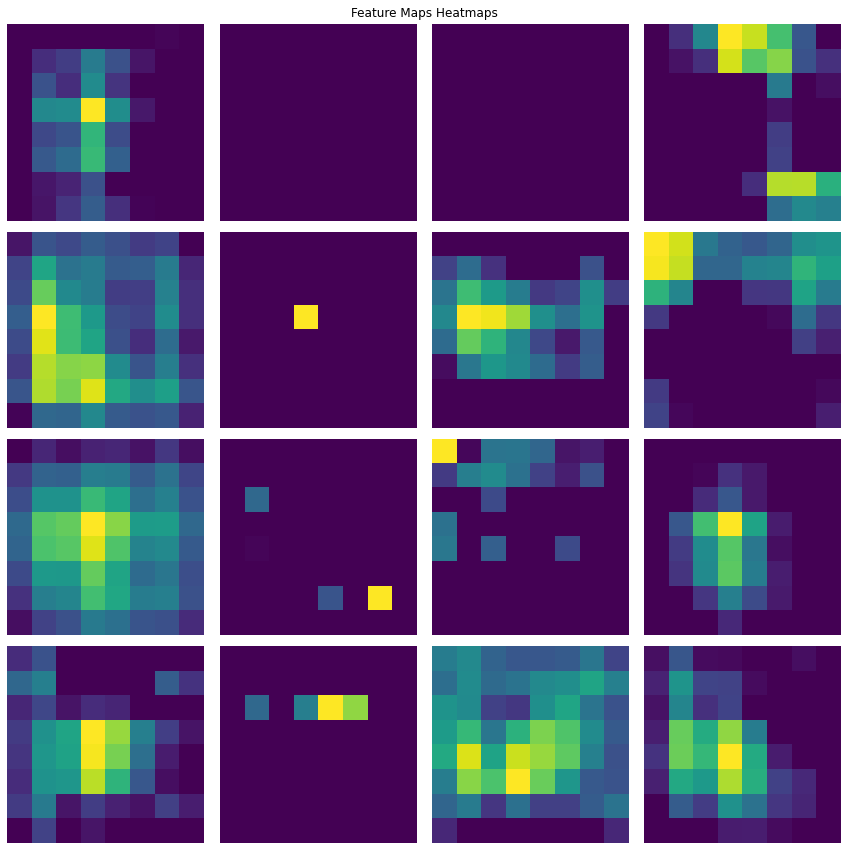

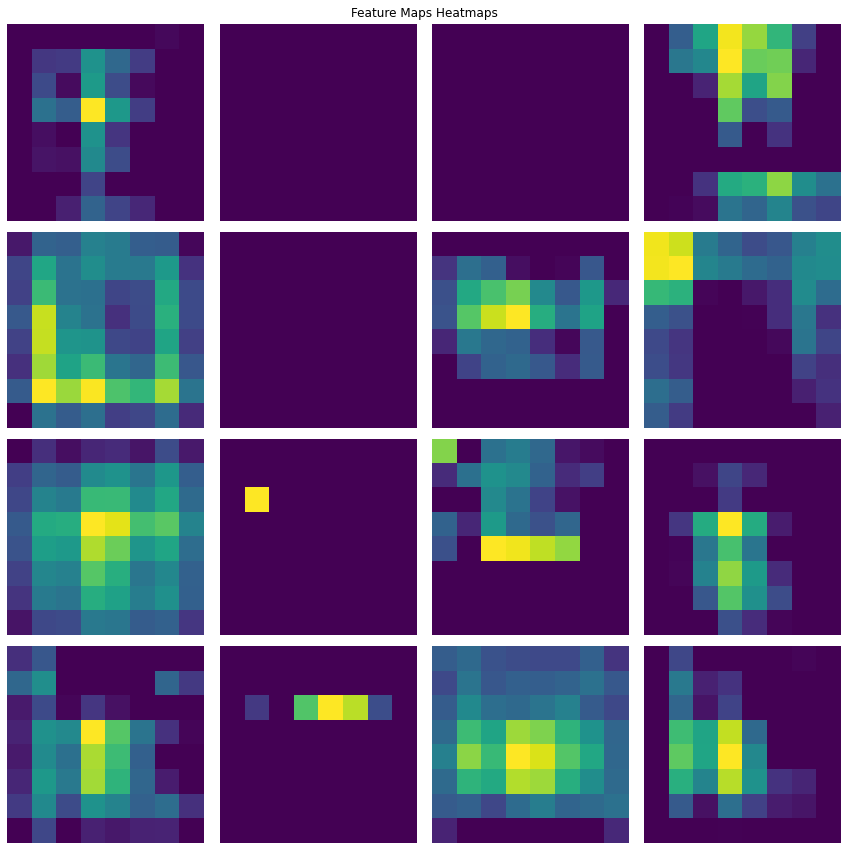

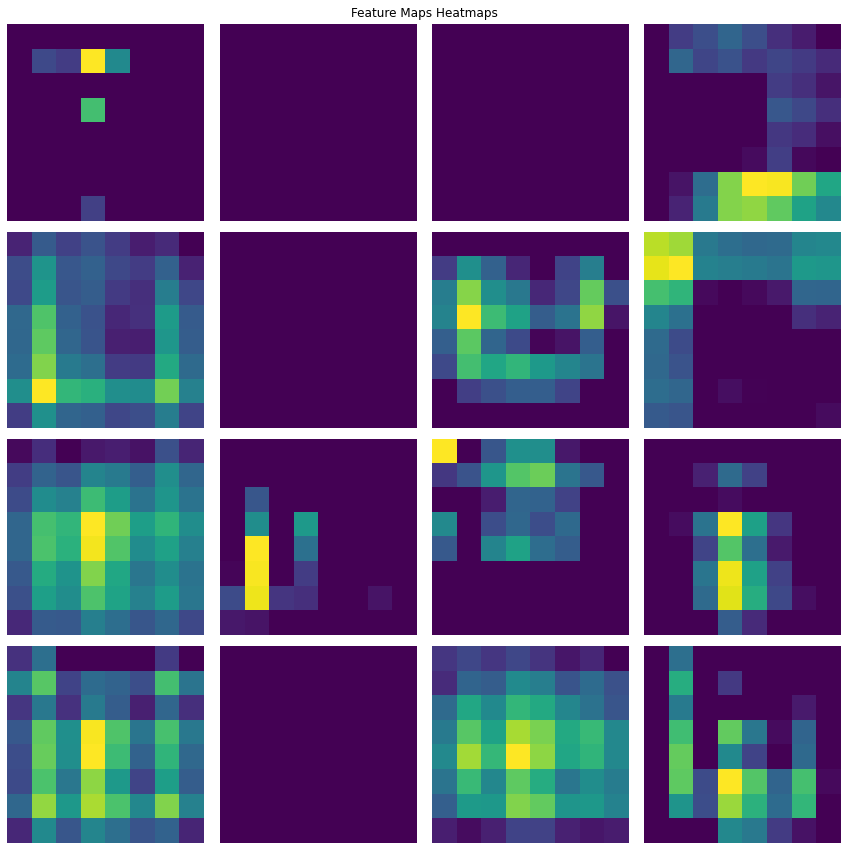

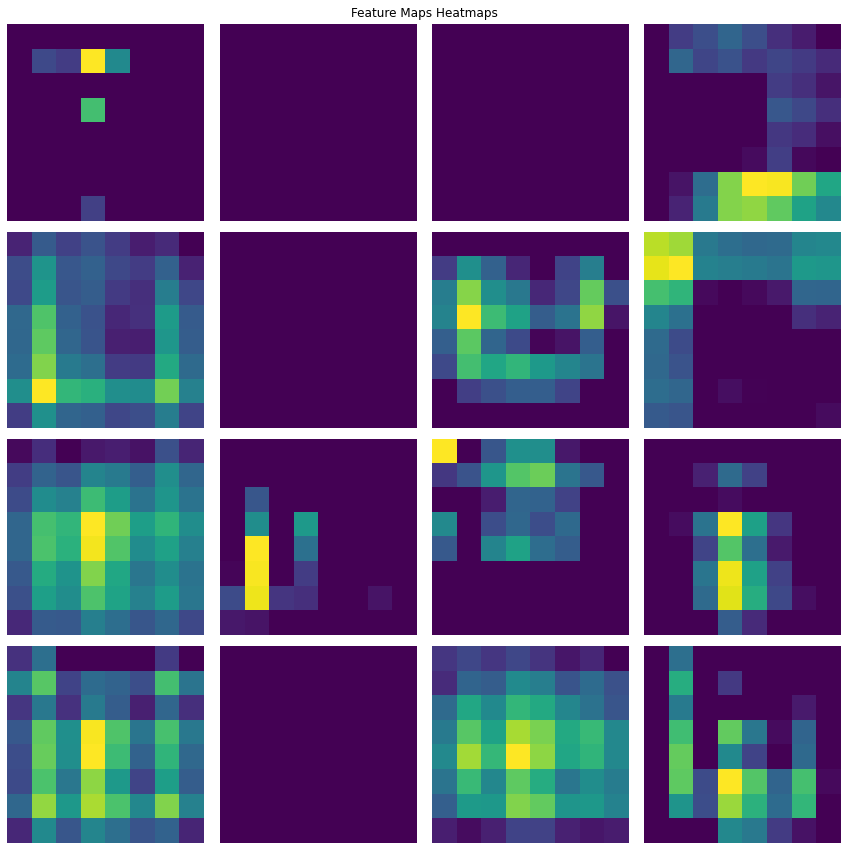

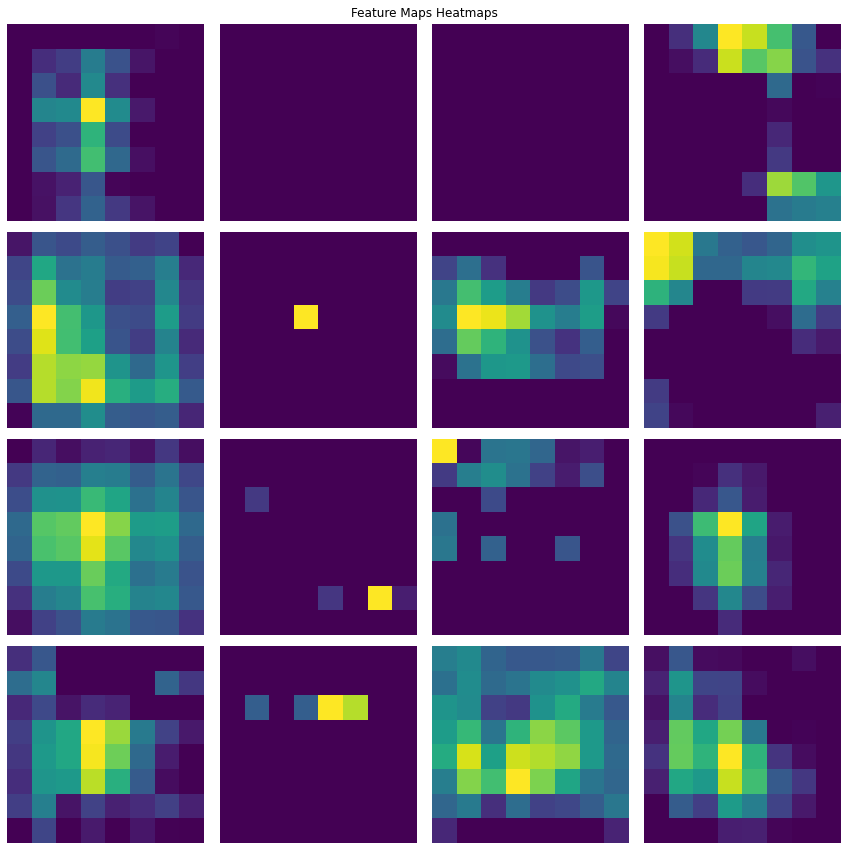

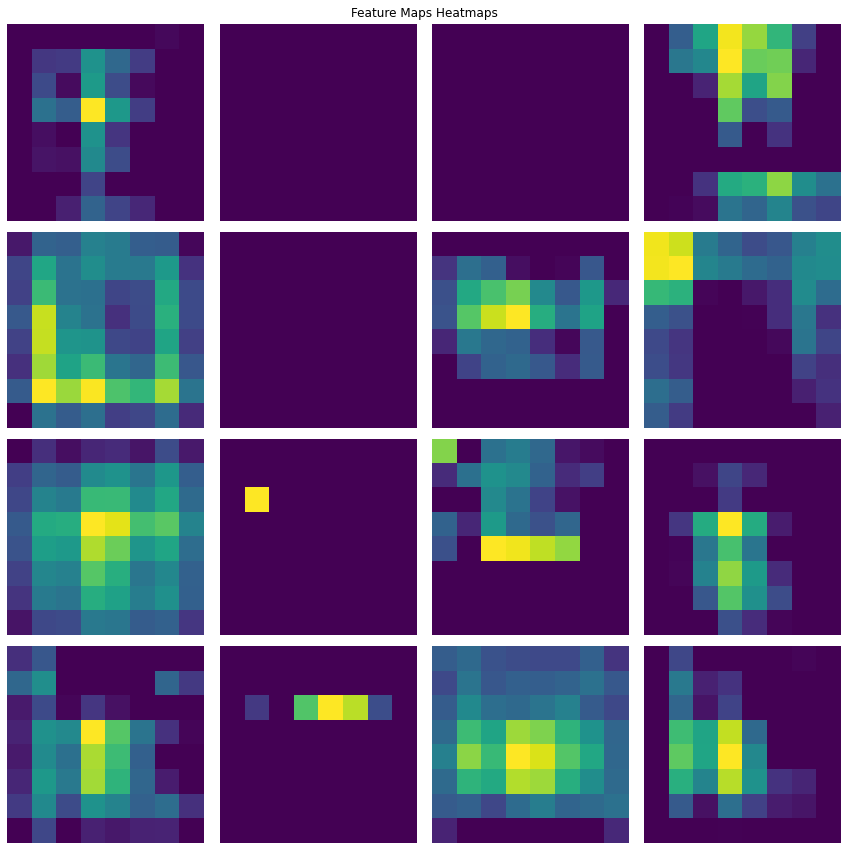

In [21]:
# Assuming `train_loader` provides batches of images
for images, labels in train_loader:
    print(labels)
    for i in range(3):  # Display for the first few images
        image_tensor = images[:, 10*i]
        feature_maps = get_feature_maps(model, image_tensor)
        # print(feature_maps.shape)
        visualize_feature_maps(feature_maps[0], num_maps=16)
        visualize_feature_maps(feature_maps[1], num_maps=16)
    break

In [2]:
test_1 = test_loader

In [4]:
test_8 = test_loader

In [9]:
import torch

def create_patch_mask(image_size=64, square_size=40, center_distance=80, stripe_indices=[0, 2, 4, 6], device='cuda'):
    """
    Creates a binary mask for a 256x256 image with 1s at patch positions and 0s elsewhere, using PyTorch GPU tensors.
    Parameters:
        - image_size: Size of the square image (default 256x256).
        - square_size: Size of each patch/square (default 40x40).
        - center_distance: Distance from the image center to each patch center.
        - stripe_indices: List of indices specifying which patches to activate (as per angles).
        - device: The device to store the mask on ('cuda' for GPU).
    Returns:
        - mask: A binary mask with 1s at patch positions and 0s elsewhere, as a PyTorch tensor.
    """
    # Initialize a blank mask on the specified device
    mask = torch.zeros((image_size, image_size), dtype=torch.float32, device=device)

    # Calculate the center of the image
    center_x, center_y = image_size // 2, image_size // 2

    # Angles for positioning the patches
    angles = torch.arange(0, 360, 45, device=device)  # 0°, 45°, 90°, ..., 315°

    # Place patches in the mask based on stripe_indices
    for idx, square_angle in enumerate(angles):
        if idx in stripe_indices:
            # Calculate the center position for the patch
            radian = torch.deg2rad(square_angle)
            square_center_x = int(center_x + center_distance * torch.cos(radian))
            square_center_y = int(center_y + center_distance * torch.sin(radian))
            
            # Calculate the top-left and bottom-right coordinates of the patch
            top_left_x = square_center_x - square_size // 2
            top_left_y = square_center_y - square_size // 2
            bottom_right_x = square_center_x + square_size // 2
            bottom_right_y = square_center_y + square_size // 2
            
            # Set the region in the mask to 1 for the patch
            mask[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 1

    return mask

# Example usage
stripe_indices = [0, 1, 2, 3, 4, 5, 6, 7]  # Choose patch indices to focus on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mask = create_patch_mask(stripe_indices=stripe_indices, device=device)


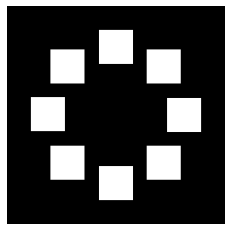

In [9]:
import matplotlib.pyplot as plt
plt.imshow(mask.cpu(), cmap='gray')  # Display in grayscale for better visualization
plt.axis('off')  # Turn off axis labels
plt.show()

In [1]:
import torch

torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PatchChangeCNN(nn.Module):
    def __init__(self):
        super(PatchChangeCNN, self).__init__()
        # First convolutional layer (change in_channels to 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # Flatten layer for RNN input
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.flatten(x)  # Flatten for RNN input
        return x

class CNN_RNN_Model(nn.Module):
    def __init__(self):
        super(CNN_RNN_Model, self).__init__()
        self.rnn_layers = 1
        self.hidden_size = 16
        stripe_indices = [0, 1, 2, 3, 4, 5, 6, 7]
        self.mask = create_patch_mask(stripe_indices=stripe_indices, device=device).unsqueeze(0).unsqueeze(0)
        # self.cnn = PatchChangeCNN()
        self.cnn = models.resnet18(pretrained=False)
        self.cnn.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(
            *list(self.cnn.children())[:-1],
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # self.cnn.eval()
        # for param in self.cnn.parameters():
        #     param.requires_grad = False
        
        self.rnn = nn.LSTM(input_size=512, hidden_size=self.hidden_size, num_layers=self.rnn_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 2)  # Output layer for binary classification (change or no change)

    def forward(self, x, hidden=None, masking=True):
        if hidden is None:
            h_0 = torch.zeros(self.rnn_layers, x.size(0), self.rnn.hidden_size).to(x.device)
            c_0 = torch.zeros(self.rnn_layers, x.size(0), self.rnn.hidden_size).to(x.device)
            hidden = (h_0, c_0)
        
        if masking:
            if (self.mask.shape[0] != x.size(0)) or (self.mask.shape[1] != x.size(1)):
                self.mask = mask.expand(x.size(0), x.size(1), -1, -1) 
                
            x = x * self.mask
        
        # plt.imshow(x[0].cpu().permute(1,2,0), cmap='gray')  # Display in grayscale for better visualization
        # plt.axis('off')  # Turn off axis labels
        # plt.show()  
            
        x = self.cnn(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)
        
        # Stack CNN features and feed to RNN
        rnn_out, hidden = self.rnn(x, hidden)
        # print(rnn_out.shape)
        
        # Classification
        output = self.fc(rnn_out[:, -1, :])  # Take the output from the last RNN time step
        
        return output, hidden


In [7]:
import torch.nn as nn
import torch.optim as optim

def train(num_epochs=100, model=None, delay_num=0):
    # Define the model, loss function, and optimizer
    if model is None:
        model = CNN_RNN_Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            hidden = None
            loss = 0.0
            
            for i in range(30):
                if 10 + delay_num <= i < 20:
                    continue
                image = images[:, i]
            # for i in range(3):
            #     image = images[:, i*10+2]
                outputs, hidden = model(image, hidden)
            
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(-1)
            total_train += images.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        total_vali = 0
        correct_vali = 0
        
        with torch.no_grad():  # Turn off gradients for validation
            for images, labels in vali_loader:
                images = images.to(device)
                labels = labels.to(device)

                hidden = None
                
                for i in range(30):
                    if 10 + delay_num <= i < 20:
                        continue
                    image = images[:, i]
                # for i in range(3):
                #     image = images[:, i*10+2]
                    outputs, hidden = model(image, hidden)
                
                val_loss = criterion(outputs, labels.long())
                running_val_loss += val_loss.item()
                predicted = outputs.argmax(-1)
                total_vali += images.size(0)
                correct_vali += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        epoch_val_loss = running_val_loss / len(vali_loader)
        vali_accuracy = 100 * correct_vali / total_vali
        print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {vali_accuracy:.2f}%')

    print('Finished Training')
    return model


In [6]:
model = train(15, model=None, delay_num=0)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15], Loss: 0.6732, Training Accuracy: 56.88%
Validation Loss: 0.6980, Validation Accuracy: 52.50%
Epoch [2/15], Loss: 0.6516, Training Accuracy: 61.04%
Validation Loss: 0.7746, Validation Accuracy: 50.00%
Epoch [3/15], Loss: 0.6277, Training Accuracy: 65.00%
Validation Loss: 0.7158, Validation Accuracy: 52.50%
Epoch [4/15], Loss: 0.6254, Training Accuracy: 63.54%
Validation Loss: 0.7252, Validation Accuracy: 50.00%
Epoch [5/15], Loss: 0.6039, Training Accuracy: 66.04%
Validation Loss: 0.7806, Validation Accuracy: 49.38%
Epoch [6/15], Loss: 0.5684, Training Accuracy: 70.83%
Validation Loss: 0.7085, Validation Accuracy: 53.75%
Epoch [7/15], Loss: 0.5917, Training Accuracy: 64.38%
Validation Loss: 0.7413, Validation Accuracy: 55.62%
Epoch [8/15], Loss: 0.5698, Training Accuracy: 67.71%
Validation Loss: 0.8596, Validation Accuracy: 50.62%
Epoch [9/15], Loss: 0.5371, Training Accuracy: 70.62%
Validation Loss: 0.7956, Validation Accuracy: 56.25%
Epoch [10/15], Loss: 0.5797, Training

In [ ]:
model = train(15, model=model, delay_num=5)

Epoch [1/15], Loss: 0.4966, Training Accuracy: 71.46%, Validation Accuracy: 60.46%
Epoch [2/15], Loss: 0.5039, Training Accuracy: 75.00%, Validation Accuracy: 69.07%
Epoch [3/15], Loss: 0.4771, Training Accuracy: 74.58%, Validation Accuracy: 65.32%
Epoch [4/15], Loss: 0.4821, Training Accuracy: 74.17%, Validation Accuracy: 64.97%
Epoch [5/15], Loss: 0.5129, Training Accuracy: 74.17%, Validation Accuracy: 64.93%
Epoch [6/15], Loss: 0.4533, Training Accuracy: 77.08%, Validation Accuracy: 71.34%
Epoch [7/15], Loss: 0.5148, Training Accuracy: 72.50%, Validation Accuracy: 71.28%
Epoch [8/15], Loss: 0.4425, Training Accuracy: 77.71%, Validation Accuracy: 74.27%
Epoch [9/15], Loss: 0.4584, Training Accuracy: 76.25%, Validation Accuracy: 72.31%
Epoch [10/15], Loss: 0.4744, Training Accuracy: 76.46%, Validation Accuracy: 69.90%
Epoch [11/15], Loss: 0.4295, Training Accuracy: 77.71%, Validation Accuracy: 68.10%
Epoch [12/15], Loss: 0.4508, Training Accuracy: 78.54%, Validation Accuracy: 71.48%
E

In [ ]:
model = train(15, model=model, delay_num=10)

Epoch [1/15], Loss: 0.4204, Training Accuracy: 83.96%, Validation Accuracy: 74.33%
Epoch [2/15], Loss: 0.3787, Training Accuracy: 81.04%, Validation Accuracy: 65.25%
Epoch [3/15], Loss: 0.3905, Training Accuracy: 82.83%, Validation Accuracy: 78.51%
Epoch [4/15], Loss: 0.3886, Training Accuracy: 83.21%, Validation Accuracy: 77.21%
Epoch [5/15], Loss: 0.3996, Training Accuracy: 84.54%, Validation Accuracy: 74.48%
Epoch [6/15], Loss: 0.4085, Training Accuracy: 88.58%, Validation Accuracy: 79.58%
Epoch [7/15], Loss: 0.3871, Training Accuracy: 88.88%, Validation Accuracy: 81.88%
Epoch [8/15], Loss: 0.3957, Training Accuracy: 90.17%, Validation Accuracy: 83.55%
Epoch [9/15], Loss: 0.3873, Training Accuracy: 91.25%, Validation Accuracy: 84.67%
Epoch [10/15], Loss: 0.3949, Training Accuracy: 92.04%, Validation Accuracy: 86.04%
Epoch [11/15], Loss: 0.3950, Training Accuracy: 92.52%, Validation Accuracy: 85.49%
Epoch [12/15], Loss: 0.3599, Training Accuracy: 94.96%, Validation Accuracy: 87.18%
E

In [19]:
model = train(50)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Loss: 0.0210, Training Accuracy: 53.12%, zeros: 17, trained zeros: 14
Validation loss: 0.0213, Validation Accuracy: 56.25%
Epoch [2/50], Loss: 0.0204, Training Accuracy: 78.12%, zeros: 15, trained zeros: 20
Validation loss: 0.0208, Validation Accuracy: 62.50%
Epoch [3/50], Loss: 0.0184, Training Accuracy: 84.38%, zeros: 16, trained zeros: 15
Validation loss: 0.0212, Validation Accuracy: 56.25%
Epoch [4/50], Loss: 0.0199, Training Accuracy: 62.50%, zeros: 16, trained zeros: 14
Validation loss: 0.0175, Validation Accuracy: 78.12%
Epoch [5/50], Loss: 0.0199, Training Accuracy: 62.50%, zeros: 19, trained zeros: 23
Validation loss: 0.0173, Validation Accuracy: 81.25%
Epoch [6/50], Loss: 0.0190, Training Accuracy: 71.88%, zeros: 18, trained zeros: 11
Validation loss: 0.0216, Validation Accuracy: 65.62%
Epoch [7/50], Loss: 0.0167, Training Accuracy: 71.88%, zeros: 18, trained zeros: 21
Validation loss: 0.0160, Validation Accuracy: 78.12%
Epoch [8/50], Loss: 0.0113, Training Accu

In [26]:
model = train(30)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.0216, Training Accuracy: 40.62%, zeros: 10, trained zeros: 15
Validation loss: 0.0218, Validation Accuracy: 50.00%
Epoch [2/30], Loss: 0.0201, Training Accuracy: 68.75%, zeros: 11, trained zeros: 7
Validation loss: 0.0214, Validation Accuracy: 56.25%
Epoch [3/30], Loss: 0.0208, Training Accuracy: 53.12%, zeros: 18, trained zeros: 21
Validation loss: 0.0212, Validation Accuracy: 65.62%
Epoch [4/30], Loss: 0.0180, Training Accuracy: 75.00%, zeros: 19, trained zeros: 19
Validation loss: 0.0185, Validation Accuracy: 71.88%
Epoch [5/30], Loss: 0.0191, Training Accuracy: 68.75%, zeros: 17, trained zeros: 11
Validation loss: 0.0185, Validation Accuracy: 71.88%
Epoch [6/30], Loss: 0.0171, Training Accuracy: 71.88%, zeros: 23, trained zeros: 18
Validation loss: 0.0150, Validation Accuracy: 78.12%
Epoch [7/30], Loss: 0.0136, Training Accuracy: 78.12%, zeros: 15, trained zeros: 16
Validation loss: 0.0166, Validation Accuracy: 75.00%
Epoch [8/30], Loss: 0.0166, Training Accur

In [10]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    running_loss = 0.0
    total_test = 0
    correct_test = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            hidden = None
            for i in range(3):  # Assuming you use 3 steps in each sequence
                image = images[:, i*10+2]
                outputs, hidden = model(image, hidden)
            
            # Calculate the loss
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

            # Calculate accuracy
            predicted = outputs.argmax(-1)
            total_test += images.shape[0]
            correct_test += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / total_test
    accuracy = 100 * correct_test / total_test
    
    print(predicted, labels.int(), sep="\n")        

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


In [ ]:
rsl = test(model, loader_for_eight)

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0', dtype=torch.int32)
Test Loss: 0.0420, Test Accuracy: 64.17%


In [ ]:
rsl = test(model, loader_for_two)

tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0', dtype=torch.int32)
Test Loss: 0.0402, Test Accuracy: 79.17%


In [23]:
model = train(30)

Epoch [1/30], Loss: 0.0208, Training Accuracy: 56.25%, zeros: 13, trained zeros: 11
Validation loss: 0.0212, Validation Accuracy: 62.50%
Epoch [2/30], Loss: 0.0203, Training Accuracy: 78.12%, zeros: 13, trained zeros: 18
Validation loss: 0.0231, Validation Accuracy: 43.75%
Epoch [3/30], Loss: 0.0222, Training Accuracy: 43.75%, zeros: 17, trained zeros: 11
Validation loss: 0.0207, Validation Accuracy: 46.88%
Epoch [4/30], Loss: 0.0207, Training Accuracy: 62.50%, zeros: 15, trained zeros: 23
Validation loss: 0.0234, Validation Accuracy: 40.62%
Epoch [5/30], Loss: 0.0190, Training Accuracy: 68.75%, zeros: 18, trained zeros: 16
Validation loss: 0.0209, Validation Accuracy: 56.25%
Epoch [6/30], Loss: 0.0135, Training Accuracy: 87.50%, zeros: 19, trained zeros: 17
Validation loss: 0.0230, Validation Accuracy: 43.75%
Epoch [7/30], Loss: 0.0180, Training Accuracy: 68.75%, zeros: 17, trained zeros: 21
Validation loss: 0.0310, Validation Accuracy: 43.75%
Epoch [8/30], Loss: 0.0124, Training Accu

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

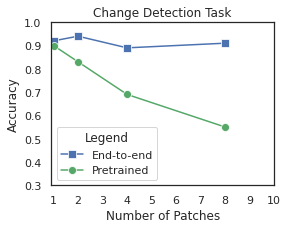

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('results.csv')

sns.set(style="white")
plt.figure(figsize=(4, 3))

sns.lineplot(x='x', y='y1', data=data, label='End-to-end', color='b', marker='s', markersize=8)
sns.lineplot(x='x', y='y2', data=data, label='Pretrained', color='g', marker='o', markersize=8)

plt.xlabel('Number of Patches')
plt.ylabel('Accuracy')
plt.title('Change Detection Task')

plt.xlim(0.9, 10)
plt.ylim(0.3, 1)
plt.xticks(range(1, 11))

plt.legend(title='Legend')

plt.show()


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


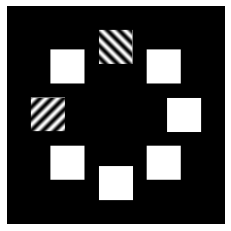

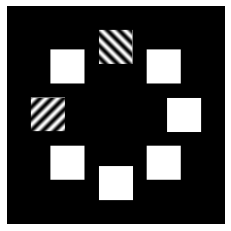

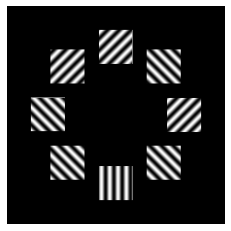

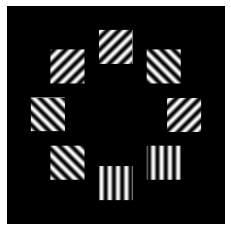

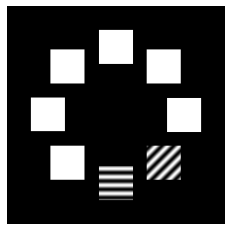

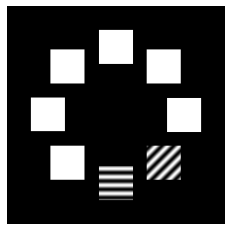

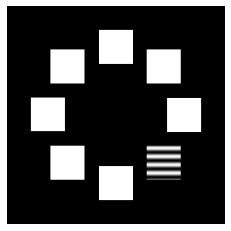

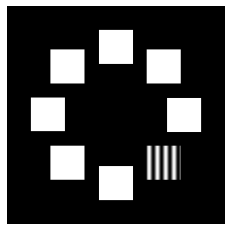

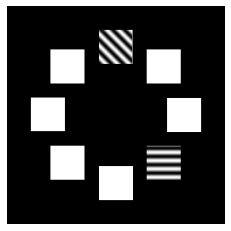

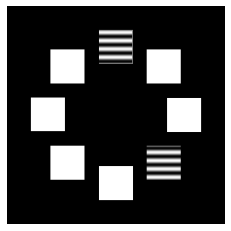

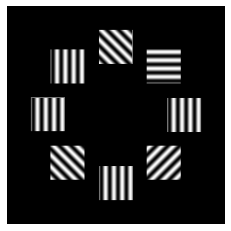

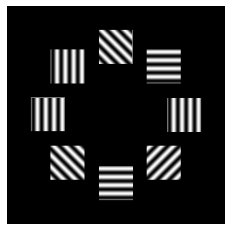

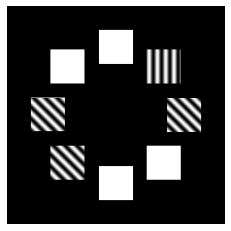

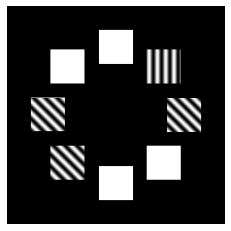

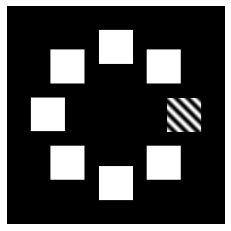

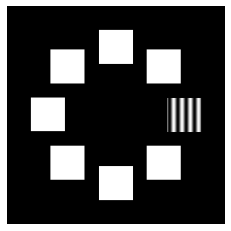

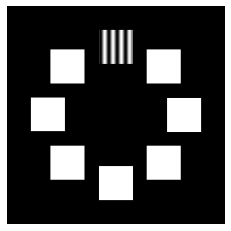

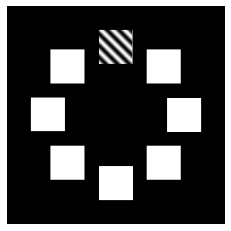

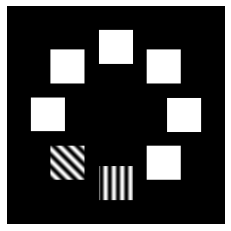

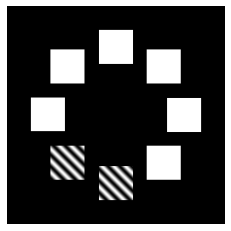

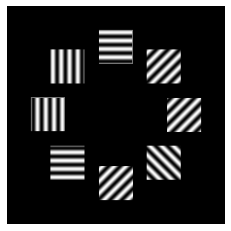

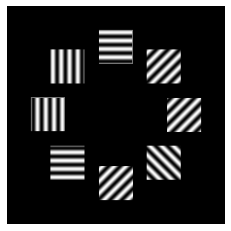

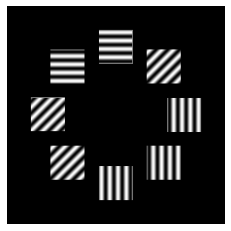

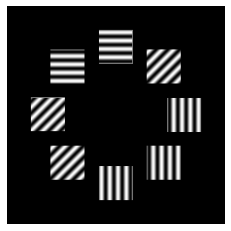

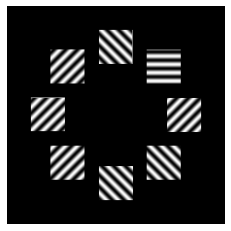

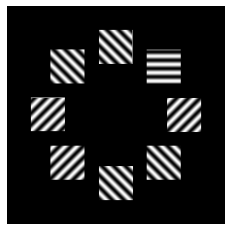

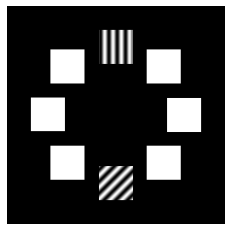

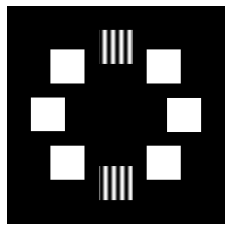

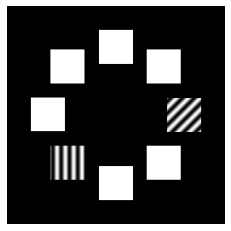

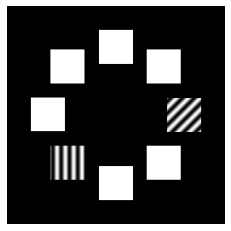

Epoch [1/1], Loss: 0.0216, Training Accuracy: 59.38%, zeros: 18, trained zeros: 25
tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0', dtype=torch.int32)
Finished Training


In [14]:
model = train(1)

In [36]:
rsl = test(model, test_loader)

tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
Test Loss: 0.0216, Test Accuracy: 54.38%


In [25]:
torch.set_printoptions(threshold=torch.inf, linewidth=200)

In [ ]:
# 100 seq pretrain unfrozen 2 images best: 72.92
model = train(30)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.0084, Training Accuracy: 51.04%
Validation loss: 0.0082, Validation Accuracy: 41.67%
Epoch [2/30], Loss: 0.0078, Training Accuracy: 40.62%
Validation loss: 0.0076, Validation Accuracy: 44.79%
Epoch [3/30], Loss: 0.0075, Training Accuracy: 48.96%
Validation loss: 0.0072, Validation Accuracy: 52.08%
Epoch [4/30], Loss: 0.0072, Training Accuracy: 54.17%
Validation loss: 0.0080, Validation Accuracy: 43.75%
Epoch [5/30], Loss: 0.0075, Training Accuracy: 54.17%
Validation loss: 0.0074, Validation Accuracy: 55.21%
Epoch [6/30], Loss: 0.0068, Training Accuracy: 62.50%
Validation loss: 0.0075, Validation Accuracy: 45.83%
Epoch [7/30], Loss: 0.0072, Training Accuracy: 60.42%
Validation loss: 0.0072, Validation Accuracy: 60.42%
Epoch [8/30], Loss: 0.0065, Training Accuracy: 65.62%
Validation loss: 0.0074, Validation Accuracy: 60.42%
Epoch [9/30], Loss: 0.0070, Training Accuracy: 59.38%
Validation loss: 0.0079, Validation Accuracy: 44.79%
Epoch [10/30], Loss: 0.0066, Training

In [ ]:
# 100 seq end-to-end 2 images best: 80.21
model = train(30)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.0077, Training Accuracy: 53.12%
Validation loss: 0.0084, Validation Accuracy: 50.00%
Epoch [2/30], Loss: 0.0074, Training Accuracy: 47.92%
Validation loss: 0.0075, Validation Accuracy: 54.17%
Epoch [3/30], Loss: 0.0072, Training Accuracy: 56.25%
Validation loss: 0.0075, Validation Accuracy: 51.04%
Epoch [4/30], Loss: 0.0082, Training Accuracy: 44.79%
Validation loss: 0.0076, Validation Accuracy: 51.04%
Epoch [5/30], Loss: 0.0070, Training Accuracy: 56.25%
Validation loss: 0.0080, Validation Accuracy: 46.88%
Epoch [6/30], Loss: 0.0070, Training Accuracy: 56.25%
Validation loss: 0.0074, Validation Accuracy: 53.12%
Epoch [7/30], Loss: 0.0071, Training Accuracy: 61.46%
Validation loss: 0.0069, Validation Accuracy: 64.58%
Epoch [8/30], Loss: 0.0066, Training Accuracy: 59.38%
Validation loss: 0.0077, Validation Accuracy: 37.50%
Epoch [9/30], Loss: 0.0073, Training Accuracy: 61.46%
Validation loss: 0.0062, Validation Accuracy: 68.75%
Epoch [10/30], Loss: 0.0074, Training

In [ ]:
# 100 seq end-to-end 1-8 patches best: 71.88 69.79
model = train(30)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.0077, Training Accuracy: 51.04%
Validation loss: 0.0080, Validation Accuracy: 43.75%
Epoch [2/30], Loss: 0.0073, Training Accuracy: 57.29%
Validation loss: 0.0072, Validation Accuracy: 59.38%
Epoch [3/30], Loss: 0.0075, Training Accuracy: 46.88%
Validation loss: 0.0077, Validation Accuracy: 43.75%
Epoch [4/30], Loss: 0.0077, Training Accuracy: 54.17%
Validation loss: 0.0075, Validation Accuracy: 50.00%
Epoch [5/30], Loss: 0.0081, Training Accuracy: 45.83%
Validation loss: 0.0071, Validation Accuracy: 57.29%
Epoch [6/30], Loss: 0.0074, Training Accuracy: 53.12%
Validation loss: 0.0080, Validation Accuracy: 48.96%
Epoch [7/30], Loss: 0.0068, Training Accuracy: 60.42%
Validation loss: 0.0072, Validation Accuracy: 52.08%
Epoch [8/30], Loss: 0.0074, Training Accuracy: 50.00%
Validation loss: 0.0069, Validation Accuracy: 62.50%
Epoch [9/30], Loss: 0.0076, Training Accuracy: 53.12%
Validation loss: 0.0064, Validation Accuracy: 68.75%
Epoch [10/30], Loss: 0.0070, Training

In [ ]:
# 100 seq end-to-end 1 patch best: 79
model = train(30)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.0088, Training Accuracy: 49.17%
Validation loss: 0.0080, Validation Accuracy: 50.83%
Epoch [2/30], Loss: 0.0066, Training Accuracy: 57.50%
Validation loss: 0.0073, Validation Accuracy: 50.83%
Epoch [3/30], Loss: 0.0061, Training Accuracy: 69.17%
Validation loss: 0.0067, Validation Accuracy: 50.83%
Epoch [4/30], Loss: 0.0059, Training Accuracy: 72.50%
Validation loss: 0.0064, Validation Accuracy: 50.83%
Epoch [5/30], Loss: 0.0057, Training Accuracy: 72.50%
Validation loss: 0.0062, Validation Accuracy: 50.83%
Epoch [6/30], Loss: 0.0054, Training Accuracy: 72.50%
Validation loss: 0.0061, Validation Accuracy: 50.83%
Epoch [7/30], Loss: 0.0050, Training Accuracy: 75.83%
Validation loss: 0.0061, Validation Accuracy: 50.83%
Epoch [8/30], Loss: 0.0046, Training Accuracy: 76.67%
Validation loss: 0.0060, Validation Accuracy: 49.17%
Epoch [9/30], Loss: 0.0043, Training Accuracy: 78.33%
Validation loss: 0.0060, Validation Accuracy: 49.17%
Epoch [10/30], Loss: 0.0041, Training

In [ ]:
# 100 seq end-to-end 8 patch best: 95
model = train(30)

Epoch [1/30], Loss: 0.0086, Training Accuracy: 49.17%
Validation loss: 0.0084, Validation Accuracy: 49.17%
Epoch [2/30], Loss: 0.0065, Training Accuracy: 75.83%
Validation loss: 0.0074, Validation Accuracy: 50.83%
Epoch [3/30], Loss: 0.0057, Training Accuracy: 79.17%
Validation loss: 0.0069, Validation Accuracy: 50.83%
Epoch [4/30], Loss: 0.0050, Training Accuracy: 80.83%
Validation loss: 0.0071, Validation Accuracy: 50.83%
Epoch [5/30], Loss: 0.0041, Training Accuracy: 85.83%
Validation loss: 0.0078, Validation Accuracy: 50.83%
Epoch [6/30], Loss: 0.0032, Training Accuracy: 90.00%
Validation loss: 0.0088, Validation Accuracy: 50.83%
Epoch [7/30], Loss: 0.0026, Training Accuracy: 92.50%
Validation loss: 0.0094, Validation Accuracy: 50.83%
Epoch [8/30], Loss: 0.0019, Training Accuracy: 95.00%
Validation loss: 0.0093, Validation Accuracy: 50.83%
Epoch [9/30], Loss: 0.0017, Training Accuracy: 94.17%
Validation loss: 0.0098, Validation Accuracy: 50.83%
Epoch [10/30], Loss: 0.0013, Training